In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
# from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

## Load data

In [27]:
name = 'single_forecast_tp_pure_sr_pretraining'

In [28]:
mrms = xr.open_dataarray('tmp/mrms.nc')

In [29]:
ens_pred = xr.open_dataarray(f'tmp/ens_pred_{name}.nc')
ens_pred_stitched = xr.open_dataarray(f'tmp/ens_pred_stitched_{name}.nc')

In [30]:
interp_ens = xr.open_dataarray('tmp/interp_ens.nc')

In [31]:
href = xr.open_dataarray('tmp/href.nc')

In [32]:
mask = xr.open_dataarray('../tmp/total_mask.nc')

## Make data compatible

In [33]:
overlap_times = np.intersect1d(interp_ens.valid_time, href.valid_time)

### Time

In [34]:
ens_pred = ens_pred.sel(valid_time=overlap_times)
ens_pred_stitched = ens_pred_stitched.sel(valid_time=overlap_times)
interp_ens = interp_ens.sel(valid_time=overlap_times)
href = href.sel(valid_time=overlap_times)
mrms = mrms.sel(valid_time=overlap_times)

### Mask

In [35]:
ens_pred = ens_pred.where(mask)
ens_pred_stitched = ens_pred_stitched.where(mask)
interp_ens = interp_ens.where(mask)
href = href.where(mask)
mrms = mrms.where(mask)

### Domain

In [79]:
interp_ens = interp_ens.sel(lat=ens_pred.lat, lon=ens_pred.lon)
href = href.sel(lat=ens_pred.lat, lon=ens_pred.lon)
mrms = mrms.sel(lat=ens_pred.lat, lon=ens_pred.lon)
ens_pred_stitched = ens_pred_stitched.sel(lat=ens_pred.lat, lon=ens_pred.lon)

## Plotting

In [70]:
def plot_comparison(valid_time, member):
    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    axs = axs.flatten()
    
    mrms.isel(valid_time=valid_time).plot(vmin=0, vmax=20, cmap='gist_ncar_r', ax=axs[0])
    axs[0].set_title('MRMS')
    href.isel(member=0, valid_time=0).plot(vmin=0, vmax=20, cmap='gist_ncar_r', ax=axs[1])
    axs[1].set_title('HREF')
    interp_ens.isel(member=0, valid_time=0).plot(vmin=0, vmax=20, cmap='gist_ncar_r', ax=axs[2])
    axs[2].set_title('Interpolated TIGGE')
    ens_pred.isel(member=0, valid_time=0).plot(vmin=0, vmax=20, cmap='gist_ncar_r', ax=axs[3])
    axs[3].set_title(name)
    for ax in axs: ax.grid()
    plt.tight_layout()

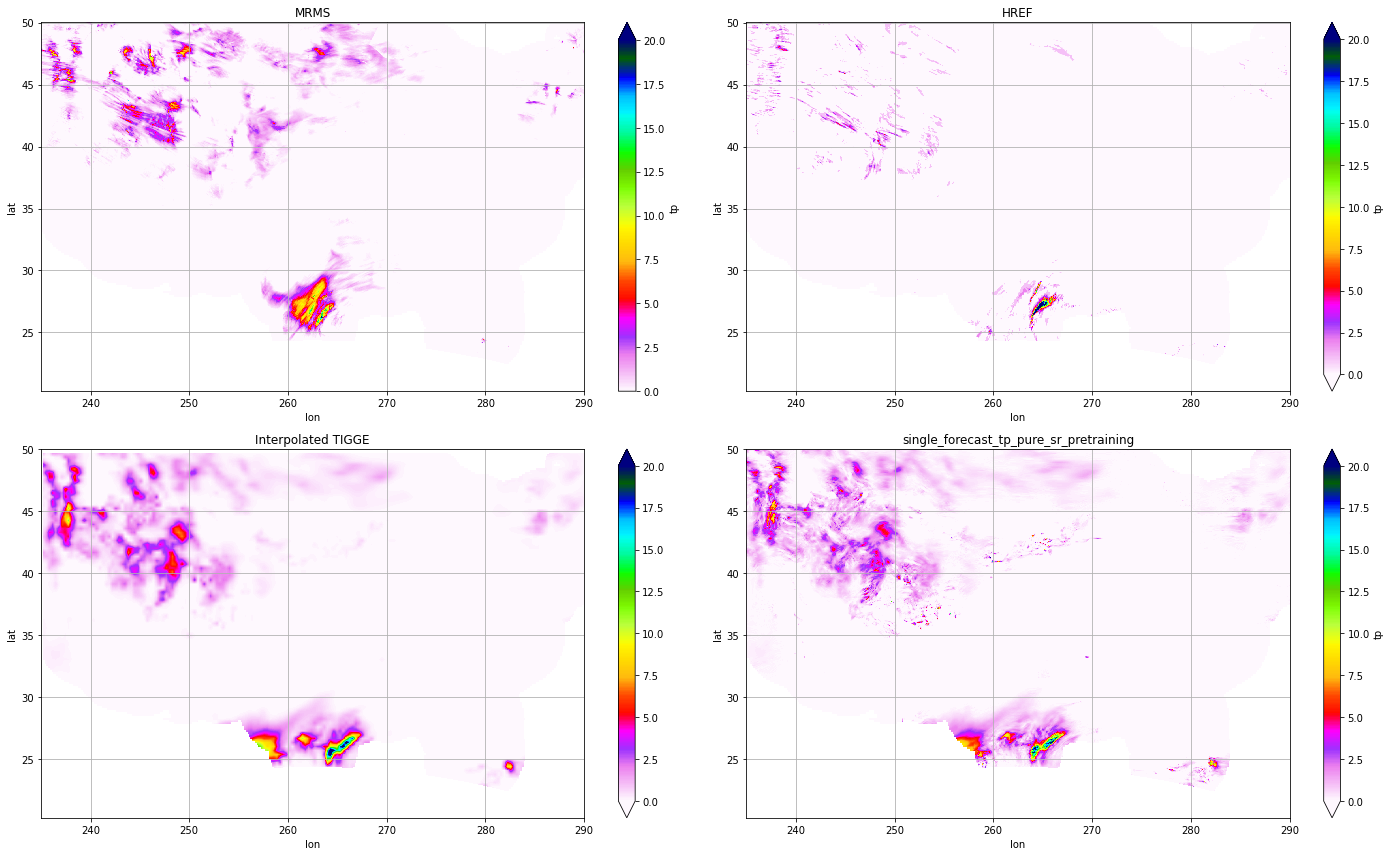

In [71]:
plot_comparison(0, 0)

## Scores

### Histograms


In [72]:
bins = np.logspace(0, 2, 25)-1
mid_bin = (bins[1:] + bins[:-1])/2

In [73]:
def plot_hist(ds, bins, label):
    nums, bins = np.histogram(ds.values, bins=bins, density=True)
    plt.plot(mid_bin, nums, marker='o', label=label)

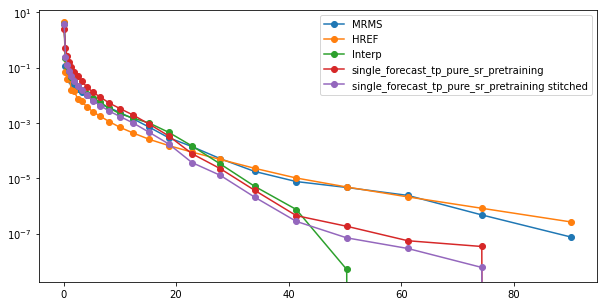

In [81]:
plt.figure(figsize=(10, 5))
plot_hist(mrms, bins, 'MRMS')
plot_hist(href, bins, 'HREF')
plot_hist(interp_ens, bins, 'Interp')
plot_hist(ens_pred, bins, name)
plot_hist(ens_pred_stitched, bins, name + ' stitched')
plt.yscale('log')
plt.legend()

### RMSE (ensemble mean)

In [86]:
exps = {'HREF': href, 'Interpolated TIGGE': interp_ens, name: ens_pred, f'{name} stitched': ens_pred_stitched}

In [88]:
for n, e in exps.items():
    score = xs.rmse(e.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values
    print(n, score)

HREF 1.8427570316954107
Interpolated TIGGE 1.525522928514815
GAN 1.5316364093763462
GAN stitched 1.5232642061961048


### CRPS

In [89]:
for n, e in exps.items():
    score = xs.crps_ensemble(mrms, e, dim=['lat', 'lon', 'valid_time']).values
    print(n, score)

HREF 0.39631195977493405
Interpolated TIGGE 0.36168230149834013
GAN 0.40008550965487566
GAN stitched 0.3885886403787917


### Brier score

In [90]:
threshold = 1
for n, e in exps.items():
    score = xs.brier_score(mrms>threshold, (e>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values
    print(n, score)

HREF 0.0467585463260347
Interpolated TIGGE 0.04388955026842646
GAN 0.048643539058592776
GAN stitched 0.04941198068071705


In [91]:
threshold = 5
for n, e in exps.items():
    score = xs.brier_score(mrms>threshold, (e>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values
    print(n, score)

HREF 0.01821144617208991
Interpolated TIGGE 0.016840427147802577
GAN 0.01978094621311578
GAN stitched 0.01887987255602963


In [92]:
threshold = 10
for n, e in exps.items():
    score = xs.brier_score(mrms>threshold, (e>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values
    print(n, score)

HREF 0.006735240939141041
Interpolated TIGGE 0.008165393399131039
GAN 0.00835529927403726
GAN stitched 0.00819015789103526


### Reliability diagram

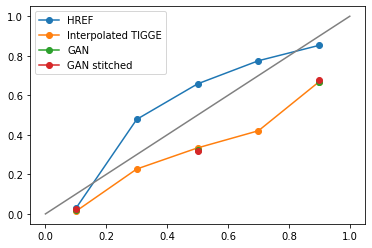

In [93]:
threshold = 1
for n, e in exps.items():
    rel = xs.reliability(mrms>threshold, (e>threshold).mean('member'))
    plt.plot(rel.forecast_probability, rel, marker='o', label=n)
plt.plot([0, 1], [0, 1], c='gray')
plt.legend()

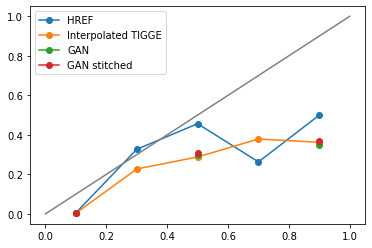

In [94]:
threshold = 10
for n, e in exps.items():
    rel = xs.reliability(mrms>threshold, (e>threshold).mean('member'))
    plt.plot(rel.forecast_probability, rel, marker='o', label=n)
plt.plot([0, 1], [0, 1], c='gray')
plt.legend()

## Rank histogram